# 2. Clustering

As the first step towards our recommender engine, we need to group the users into clusters. This notebook begins with a building our dataframe by merging all data together to all_orders. Then we proceed to feature generate aisles per share before doing a PCA to reduce the number of features (products that is) to increase performance before using kmeans to cluster into the optimal set op segments. 

In [1]:
import pandas as pd
import sys
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans
import seaborn as sns
import pyarrow as pa
import pyarrow.parquet as pq

## 2.1 Preparing the dataframe 

In [2]:
#loading all the data from the instacart zip 
products = pd.read_csv('../data/products.csv')
aisles = pd.read_csv('../data/aisles.csv')
departments = pd.read_csv('../data/departments.csv')
order_products_prior = pd.read_csv('../data/order_products__prior.csv')
order_products_train = pd.read_csv('../data/order_products__train.csv')
orders = pd.read_csv('../data/orders.csv')
sample_submission = pd.read_csv('../data/sample_submission.csv')

In [3]:
#creating one big dataframe called all_orders with most of the features included. 
all_orders = pd.concat([order_products_prior,order_products_train])
all_orders = all_orders.merge(orders[['order_id','user_id']], on='order_id', how='inner')
all_orders = all_orders.merge(products, on = 'product_id', how='inner')
all_orders = all_orders.merge(departments, on = 'department_id', how='inner')
all_orders = all_orders.merge(aisles, on = 'aisle_id', how='inner')


## 2.2 Feature Engineering "Aisle Share"

Before running our kmeans clustering algorithm, we wanted to develop a feature that would capture the relationship between the products purchased and aisles per user. We did this by counting the total number of products by aisle over total products purchased. 

In [4]:
#How many products the user bought by aisle over all their orders. 
cnt_per_aisle = all_orders[['user_id','aisle','product_name']].groupby(['user_id', 'aisle']).count().reset_index() 

cnt_per_aisle = cnt_per_aisle.rename(columns={'product_name':'product_cnt_per_aisle'})

In [5]:
cnt_per_aisle

,user_id,aisle,product_cnt_per_aisle
0,1,candy chocolate,2
1,1,cereal,4
2,1,cream,3
3,1,fresh fruits,5
4,1,milk,1
...,...,...,...
5919835,206209,soft drinks,11
5919836,206209,soy lactosefree,10
5919837,206209,spices seasonings,1
5919838,206209,trash bags liners,1


In [6]:
#Total product purchased by user id 
ttl_per_user = cnt_per_aisle.groupby(["user_id"]).sum()
ttl_per_user

,product_cnt_per_aisle
user_id,
1,70
2,226
3,88
4,18
5,46
...,...
206205,51
206206,285
206207,223


In [7]:
#calculating the aisle share by user id 
aisle_share_per_user = cnt_per_aisle.merge(ttl_per_user, how="left", on="user_id")
aisle_share_per_user["aisle_share"] = aisle_share_per_user["product_cnt_per_aisle_x"] / aisle_share_per_user["product_cnt_per_aisle_y"]
aisle_share_per_user.drop(["product_cnt_per_aisle_x", "product_cnt_per_aisle_y"], axis=1, inplace=True)
aisle_share_per_user

,user_id,aisle,aisle_share
0,1,candy chocolate,0.028571
1,1,cereal,0.057143
2,1,cream,0.042857
3,1,fresh fruits,0.071429
4,1,milk,0.014286
...,...,...,...
5919835,206209,soft drinks,0.080292
5919836,206209,soy lactosefree,0.072993
5919837,206209,spices seasonings,0.007299
5919838,206209,trash bags liners,0.007299


## 2.3 Preparing our dataset for dimensionality reduction

Before performing our principal component analysis we need to adjust our dataframe using pivot to transform our aisle per share into columns (features). 

In [8]:
#Setting aisles as columns by user id using pivot. 
aisle_share_pivot = aisle_share_per_user.pivot(index="user_id", columns="aisle", values="aisle_share")
aisle_share_pivot

aisle,air fresheners candles,asian foods,baby accessories,baby bath body care,baby food formula,bakery desserts,baking ingredients,baking supplies decor,beauty,beers coolers,...,spreads,tea,tofu meat alternatives,tortillas flat bread,trail mix snack mix,trash bags liners,vitamins supplements,water seltzer sparkling water,white wines,yogurt
user_id,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.014286,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.028571
2,NaN,0.013274,NaN,NaN,NaN,NaN,0.008850,NaN,NaN,NaN,...,0.013274,0.004425,0.004425,NaN,NaN,NaN,NaN,0.008850,NaN,0.185841
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.045455,0.011364,NaN,NaN,NaN,NaN,NaN,0.022727,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.055556,NaN,NaN,NaN,0.055556,NaN,NaN
5,0.021739,0.086957,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.065217
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
206205,NaN,NaN,0.019608,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.176471
206206,NaN,0.014035,NaN,NaN,NaN,NaN,0.014035,0.003509,NaN,NaN,...,0.003509,NaN,NaN,NaN,NaN,0.003509,NaN,0.003509,NaN,NaN
206207,NaN,NaN,NaN,NaN,0.004484,NaN,NaN,NaN,NaN,NaN,...,0.013453,0.017937,NaN,0.008969,0.004484,NaN,NaN,0.049327,NaN,0.067265


## 2.4 Dimensionality reduction using PCA 
with 134 features (columns from our pivot) PCA can help us reduce the complexity and size by lowering the dimensionality without loosing out on too much explained variance. 

### 2.4.1 Finding the optimal number of dimensions

In [9]:
#transforming our using PCA and finding the optimal explained variance with a given threshold of 80%
pca = PCA()
pca.fit_transform(aisle_share_pivot.fillna(0))
cumsum = np.cumsum(pca.explained_variance_ratio_)
threshold = 0.80 #tried differnet trsh
d = np.argmax(cumsum >= threshold) + 1

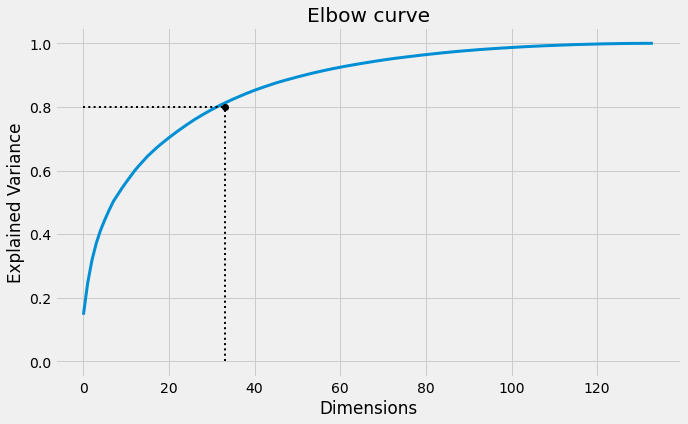

In [10]:
#graphically displaying the optimal components 
plt.style.use("fivethirtyeight")
plt.figure(figsize=(10,6))
plt.plot(cumsum, linewidth=3)
plt.title("Elbow curve")
plt.xlabel("Dimensions")
plt.ylabel("Explained Variance")
plt.plot([d, d], [0, threshold], "k:", linewidth=2)
plt.plot([0, d], [threshold, threshold], "k:",linewidth=2)
plt.plot(d, threshold, "ko")
plt.grid(True)
plt.show()

In [11]:
d

33

Using the elbow curve and a threshold of 80% explained variance, we find the optimal nubmer of dimensions to be 33. We will now create a seperate 

### 2.4.2 Reducing our dataframe using 33 components

In [12]:
#creating a dataframe with d number of components. 
pca = PCA(n_components=d)
prinicpalComponents = pca.fit_transform(aisle_share_pivot.fillna(0))

PCA_components = pd.DataFrame(prinicpalComponents)

In [13]:
PCA_components

,0,1,2,3,4,5,6,7,8,9,...,23,24,25,26,27,28,29,30,31,32
0,-0.122382,0.028613,-0.047847,0.012768,-0.075248,-0.111787,-0.100818,0.088247,-0.063891,-0.002327,...,-0.001657,0.085930,0.030833,0.097611,0.023362,-0.033896,-0.012148,0.011898,0.010086,-0.011608
1,-0.034421,0.111616,-0.064131,-0.109467,0.073282,-0.029574,-0.049193,-0.058590,-0.010443,-0.018605,...,0.037690,0.009653,-0.003040,-0.002921,-0.001685,-0.000210,-0.006641,-0.022449,-0.007180,0.032474
2,0.063256,0.104112,0.000496,-0.014156,-0.047740,0.111110,-0.031842,0.012993,0.011893,0.004929,...,0.058003,-0.005358,-0.000943,0.015343,-0.004766,-0.002963,0.003552,0.003616,-0.022263,-0.012563
3,-0.094301,0.052755,0.001039,-0.005058,-0.071590,-0.017785,-0.025065,-0.038981,0.010024,-0.014078,...,0.008062,0.006507,0.002337,0.010282,-0.016016,0.008430,0.003961,-0.072847,0.069092,0.019980
4,0.089432,-0.031068,-0.022805,-0.011826,0.042320,0.111465,-0.015766,0.100995,0.025137,-0.036509,...,-0.005929,0.009259,0.002943,-0.006791,-0.000986,0.001242,0.003653,0.006899,-0.008532,-0.003455
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
206204,0.001716,0.084855,-0.065398,-0.068636,0.114987,-0.028520,0.020652,0.023953,-0.027577,-0.016824,...,-0.004143,-0.024263,-0.006057,0.028776,0.000092,-0.006836,-0.018565,-0.018222,0.007244,0.039015
206205,-0.089658,-0.046734,-0.048290,0.012791,-0.059582,-0.000547,-0.013956,-0.042905,0.143135,-0.060007,...,0.001326,0.045842,-0.008632,0.029755,0.028316,-0.034727,0.001198,-0.011163,-0.007053,-0.015075
206206,-0.024827,-0.013520,-0.003968,-0.030920,0.032993,0.020691,0.037639,0.032877,-0.022764,-0.002578,...,0.005952,-0.002105,0.012660,-0.009850,0.004173,-0.003261,-0.005333,-0.006519,-0.010967,0.000160
206207,-0.009310,-0.003375,-0.045594,-0.012232,0.013766,0.055679,0.008126,0.029504,-0.010694,0.020757,...,-0.011417,-0.001628,-0.008062,0.012887,-0.000442,-0.005561,0.005426,0.003138,-0.016982,0.002647


In [14]:
#sns.pairplot(PCA_components[range(d)])

## 2.5 Segmenting our users using K-Means

### 2.5.1 Find optimal number of clusters using elbow method

Using 3 different methods we evaluate the optimal number of clusters to use for our segmentation. 

In [15]:
#finding optimal number of clusters. 
sse = {}
labels = {}
for k in range(2,20):
    print(k)
    kmeans = KMeans(n_clusters = k).fit(PCA_components[range(d)])
    sse[k] = kmeans.inertia_
    labels[k] = kmeans.labels_

2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


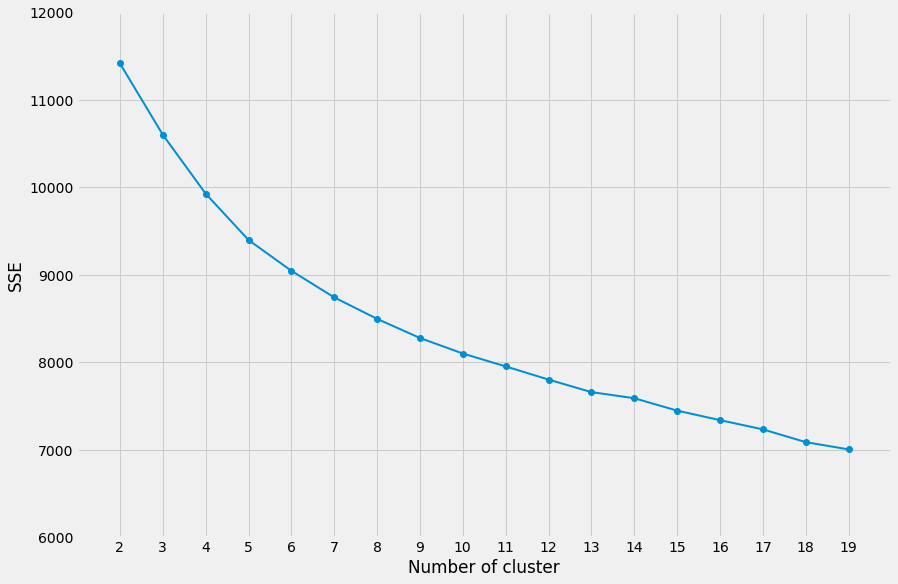

In [16]:
plt.figure(figsize=(13,9))
plt.plot(list(sse.keys()), list(sse.values()), "-o", linewidth=2)
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.ylim(6000, 12000)
plt.xlim(1,20)
plt.xticks(range(2,20))
plt.show()

Using the elbow method in this case is hard as there is no significant change in slope. 

Instead, we can find the place in which the slow down in pct %-change is the greatest.


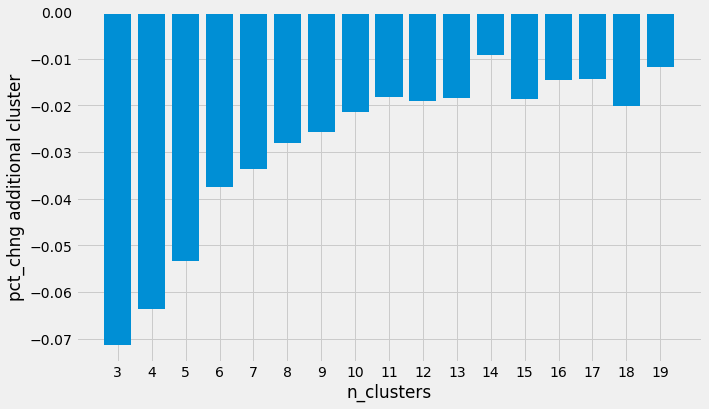

In [17]:
pct_change_clusters = pd.Series(sse.values()).pct_change()

plt.figure(figsize=(10,6))
plt.bar(sse.keys(), pct_change_clusters)
plt.xlabel("n_clusters")
plt.ylabel("pct_chng additional cluster")
plt.xticks(np.arange(3,20))
plt.show()

Looking at the bar chart graph we can see, that around 13 the pct changes kind of start balancing out. As such we decided to go for a cluster number of 13

In [18]:
# Setting k to 13 
k = 13

In [19]:
# Filling the NaN with 0
aisle_share_pivot = aisle_share_pivot.fillna(0)

### 2.5.2 Alternative Clustering methods 

During our clustering we had a branch that explored DBSCAN/OPTICS as an alternative method for segmentation. However, due to the size of the dataset DBSCAN quickly ran out of memory as the algorithm in SciKit Learn is optimized towards performance. OPTICS however could solve this but the computational time never concluded. Therefore, K-Means was the optimal clustering algorithm for this size of data. 

## 2.6 Preparing our dataframe for collaborative filtering

We can now prepare our dataframe for export to use in our collaborative filtering in the next section. This is done over a few steps of merging dataframes with the goal of shaping a final df consisting of order_id, product_id, cluster & user_id.


In [20]:
#concatting cluster onto 
cluster_df = pd.concat([PCA_components[range(d)], pd.Series(labels[k]).rename('cluster')], axis = 1)

cluster_df = pd.concat([pd.Series(aisle_share_pivot.index),cluster_df],axis = 1)

In [21]:
cluster_df

,user_id,0,1,2,3,4,5,6,7,8,...,24,25,26,27,28,29,30,31,32,cluster
0,1,-0.122382,0.028613,-0.047847,0.012768,-0.075248,-0.111787,-0.100818,0.088247,-0.063891,...,0.085930,0.030833,0.097611,0.023362,-0.033896,-0.012148,0.011898,0.010086,-0.011608,8
1,2,-0.034421,0.111616,-0.064131,-0.109467,0.073282,-0.029574,-0.049193,-0.058590,-0.010443,...,0.009653,-0.003040,-0.002921,-0.001685,-0.000210,-0.006641,-0.022449,-0.007180,0.032474,9
2,3,0.063256,0.104112,0.000496,-0.014156,-0.047740,0.111110,-0.031842,0.012993,0.011893,...,-0.005358,-0.000943,0.015343,-0.004766,-0.002963,0.003552,0.003616,-0.022263,-0.012563,7
3,4,-0.094301,0.052755,0.001039,-0.005058,-0.071590,-0.017785,-0.025065,-0.038981,0.010024,...,0.006507,0.002337,0.010282,-0.016016,0.008430,0.003961,-0.072847,0.069092,0.019980,1
4,5,0.089432,-0.031068,-0.022805,-0.011826,0.042320,0.111465,-0.015766,0.100995,0.025137,...,0.009259,0.002943,-0.006791,-0.000986,0.001242,0.003653,0.006899,-0.008532,-0.003455,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
206204,206205,0.001716,0.084855,-0.065398,-0.068636,0.114987,-0.028520,0.020652,0.023953,-0.027577,...,-0.024263,-0.006057,0.028776,0.000092,-0.006836,-0.018565,-0.018222,0.007244,0.039015,9
206205,206206,-0.089658,-0.046734,-0.048290,0.012791,-0.059582,-0.000547,-0.013956,-0.042905,0.143135,...,0.045842,-0.008632,0.029755,0.028316,-0.034727,0.001198,-0.011163,-0.007053,-0.015075,12
206206,206207,-0.024827,-0.013520,-0.003968,-0.030920,0.032993,0.020691,0.037639,0.032877,-0.022764,...,-0.002105,0.012660,-0.009850,0.004173,-0.003261,-0.005333,-0.006519,-0.010967,0.000160,6
206207,206208,-0.009310,-0.003375,-0.045594,-0.012232,0.013766,0.055679,0.008126,0.029504,-0.010694,...,-0.001628,-0.008062,0.012887,-0.000442,-0.005561,0.005426,0.003138,-0.016982,0.002647,7


In [22]:
#Adding cluster number to our asile share per user dataframe 
cluster_aisle_br = aisle_share_per_user.merge(cluster_df[['user_id','cluster']], on = 'user_id')

In [23]:
cluster_aisle_br

,user_id,aisle,aisle_share,cluster
0,1,candy chocolate,0.028571,8
1,1,cereal,0.057143,8
2,1,cream,0.042857,8
3,1,fresh fruits,0.071429,8
4,1,milk,0.014286,8
...,...,...,...,...
5919835,206209,soft drinks,0.080292,12
5919836,206209,soy lactosefree,0.072993,12
5919837,206209,spices seasonings,0.007299,12
5919838,206209,trash bags liners,0.007299,12


In [24]:
all_orders_cluster = all_orders.merge(cluster_df[['user_id','cluster']], on = 'user_id')

In [25]:
all_orders_cluster

,order_id,product_id,add_to_cart_order,reordered,user_id,product_name,aisle_id,department_id,department,aisle,cluster
0,2,33120,1,1,202279,Organic Egg Whites,86,16,dairy eggs,eggs,6
1,104690,33120,2,1,202279,Organic Egg Whites,86,16,dairy eggs,eggs,6
2,132412,33120,1,1,202279,Organic Egg Whites,86,16,dairy eggs,eggs,6
3,2808715,33120,1,1,202279,Organic Egg Whites,86,16,dairy eggs,eggs,6
4,2894949,33120,5,0,202279,Organic Egg Whites,86,16,dairy eggs,eggs,6
...,...,...,...,...,...,...,...,...,...,...,...
33819101,2942910,36885,1,1,95228,Rose,134,5,alcohol,specialty wines champagnes,12
33819102,77392,47713,1,1,95228,Sparkling Rose,134,5,alcohol,specialty wines champagnes,12
33819103,679020,47713,1,1,95228,Sparkling Rose,134,5,alcohol,specialty wines champagnes,12
33819104,1264096,47713,1,1,95228,Sparkling Rose,134,5,alcohol,specialty wines champagnes,12


3346083

## 2.7 Exploring the clusters

In [26]:
user_per_cluster = all_orders_cluster.groupby("cluster").nunique()["user_id"]

In [27]:
user_per_cluster

cluster
0      2403
1      5223
2     24053
3      7122
4      8988
5      1570
6     41490
7     34031
8      2669
9     10331
10     4922
11    17032
12    46375
Name: user_id, dtype: int64

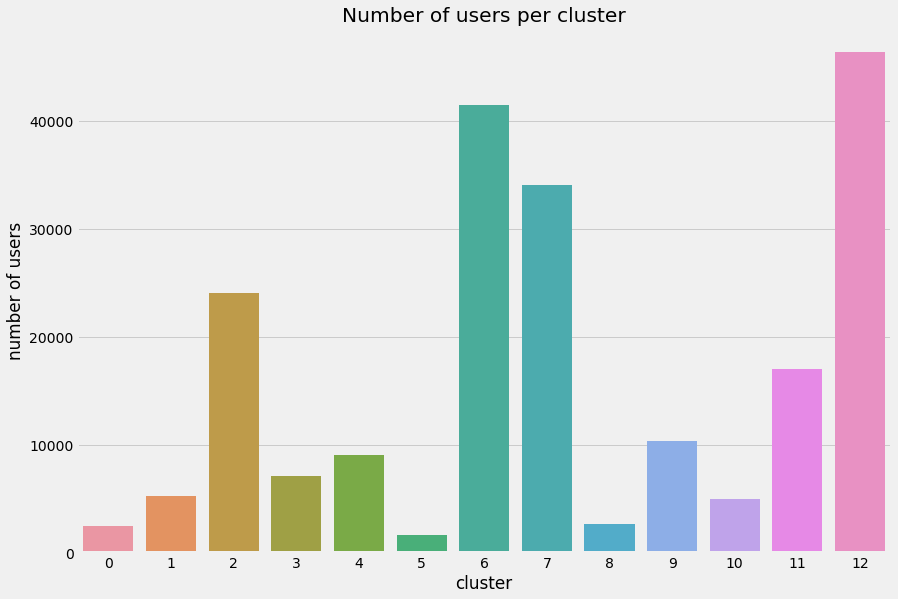

In [28]:
plt.figure(figsize=(13,9))
sns.barplot(x = user_per_cluster.index, y=user_per_cluster.values)
plt.title("Number of users per cluster")
plt.xlabel("cluster")
plt.ylabel("number of users")
plt.show()

In [29]:
orders_per_cluster=all_orders_cluster.groupby("cluster")["order_id"].nunique()

In [30]:
sum(orders_per_cluster.values)

3346083

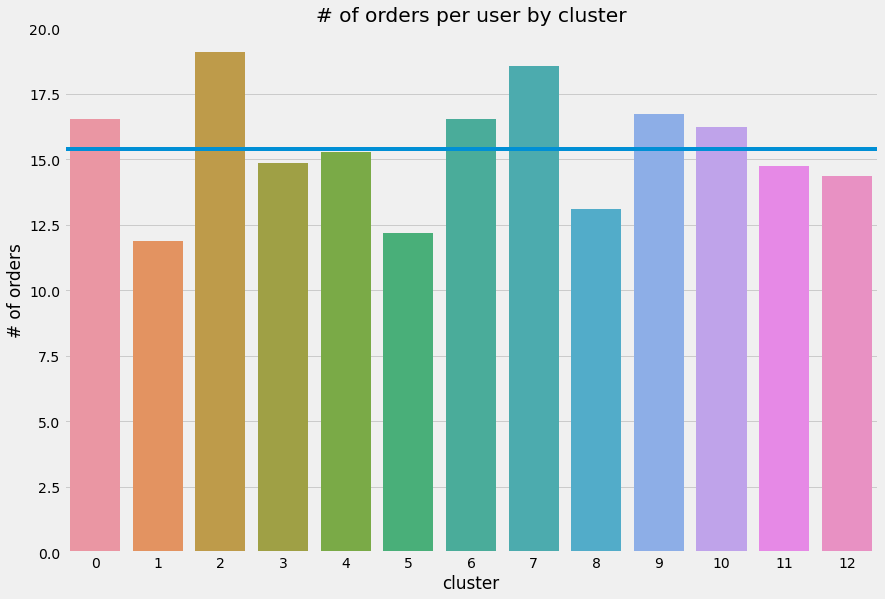

In [32]:
plt.figure(figsize=(13,9))
sns.barplot(x=orders_per_cluster.index, y=orders_per_cluster.values/user_per_cluster.values).axhline(np.mean(orders_per_cluster.values/user_per_cluster.values))
plt.title("# of orders per user by cluster")
plt.ylabel("# of orders")
plt.show()

In [41]:
avg_num_prod_per_order_by_cluster = all_orders_cluster.groupby(["cluster","order_id"]).count()["product_id"].groupby("cluster").mean()

In [43]:
avg_num_prod_per_order_by_cluster

cluster
0      4.179402
1     10.261843
2     11.205377
3      4.715577
4      6.735580
5      3.573171
6     11.734575
7     11.014122
8      4.190341
9     10.396349
10     5.240588
11    10.414821
12     9.593256
Name: product_id, dtype: float64

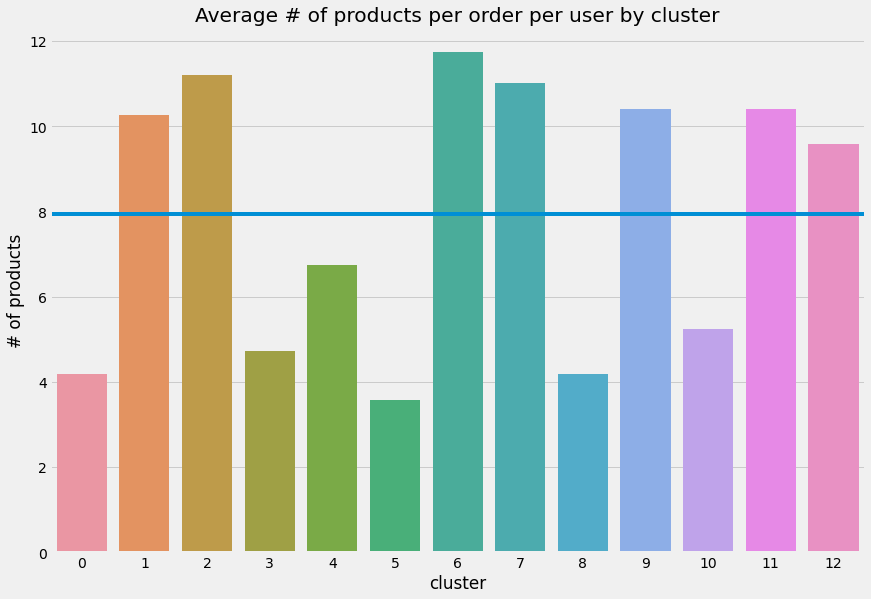

In [48]:
plt.figure(figsize=(13,9))
sns.barplot(x=avg_num_prod_per_order_by_cluster.index, y=avg_num_prod_per_order_by_cluster.values).axhline(np.mean(avg_num_prod_per_order_by_cluster))
plt.title("Average # of products per order per user by cluster")
plt.ylabel("# of products")
plt.show()

In [71]:
a = pd.DataFrame(all_orders_cluster.groupby(['cluster',"department"]).count())
a

order_id  product_id  add_to_cart_order  reordered  \
cluster department                                                          
0       alcohol             890         890                890        890   
        babies             1051        1051               1051       1051   
        bakery             5196        5196               5196       5196   
        beverages         15789       15789              15789      15789   
        breakfast          5260        5260               5260       5260   
...                         ...         ...                ...        ...   
12      pantry           447433      447433             447433     447433   
        personal care    173422      173422             173422     173422   
        pets              54165       54165              54165      54165   
        produce          707732      707732             707732     707732   
        snacks           842303      842303             842303     842303   

                       user_id  product_name  aisle_id  department_id   aisle  
cluster department                                                             
0       alcohol            890           890       890            890     890  
        babies            1051          1051      1051           1051    1051  
        bakery            5196          5196      5196           5196    5196  
        beverages        15789         15789     15789          15789   15789  
        breakfast         5260          5260      5260           5260    5260  
...                        ...           ...       ...            ...     ...  
12      pantry          447433        447433    447433         447433  447433  
        personal care   173422        173422    173422         173422  173422  
        pets             54165         54165     54165          54165   54165  
        produce         707732        707732    707732         707732  707732  
        snacks          842303        842303    842303         842303  842303  

[273 rows x 9 columns]

In [93]:
df_m = a[["order_id"]].unstack()

df_m

order_id                                                         \
department  alcohol  babies  bakery beverages breakfast  bulk canned goods   
cluster                                                                      
0               890    1051    5196     15789      5260   116         1907   
1              4326    3341   20946     58737     15303   245        21785   
2              1715   48962  143878    234848     75643  7541       159640   
3              1758      50   12718     30550      8262  1172         9792   
4              7733    4945   23648    273195     21627  1032        14224   
5               335      57     854     45057       789    45          234   
6             24331   95350  302957    531789    145040  8648       353810   
7             12600  161417  284851    531450    173871  7053       181642   
8              2528     157    2641     60330      3521   143         1355   
9              3527   21820   59165    157327     54235  1664        37190   
10              636     614    8747     25961      6383   662         3467   
11             1261    8777   55699    110864     24892  4478       108813   
12            97654   92202  303881    728278    204243  3133       220998   

                                               ...                          \
department dairy eggs    deli dry goods pasta  ... household international   
cluster                                        ...                           
0               71925    3185            1707  ...      3446           504   
1               80866   21221           15707  ...     18837          4995   
2              790904  148580          122912  ...     49107         37176   
3               45888    9362            2876  ...      7987           379   
4              121844   22439           10590  ...     39704          5118   
5                5001     840             122  ...      2002           171   
6             1324967  280314          267653  ...    152630         91673   
7             1245935  262653          180283  ...    115061         46671   
8               12790    1926            1010  ...      6839           539   
9              586085   54658           34193  ...     28638          9819   
10              54634    7325            2500  ...      4004          1017   
11             322576   65495           63286  ...     28067         27814   
12             967652  217542          202501  ...    318330         55279   

                                                                              \
department meat seafood missing  other  pantry personal care   pets  produce   
cluster                                                                        
0                  1792     175    168    7506          1799    207    23916   
1                 10152    1864    977   29687         12843   5655    79225   
2                117345   10507   4149  252202         38342   3170  2362264   
3                  7138     228    174   21569          2269     29   278704   
4                 10148    2613   1295   41213         20552   3941   126127   
5                   163     143     24    1639           743     38     3784   
6                214644   19744   8437  563017         96458  18862  2416405   
7                139998   14333   6495  346219         78254  10723  1973795   
8                  1277     174    293    5454          2063    453    11337   
9                 23574    5170   1520   71899         19795   2932   337220   
10                 3469     485    356   11969          2331     87   239036   
11                65734    5774   2124  157012         19822   1959  1328833   
12               143804   16186  12074  447433        173422  54165   707732   

                    
department  snacks  
cluster             
0            13381  
1            60888  
2           283320  
3            38505  
4           128793  
5             5218  
6           592548  
7           692137  
8

In [94]:
df_m.divide(avg_num_prod_per_order_by_cluster.values, axis=0)

order_id                                            \
department       alcohol        babies        bakery     beverages   
cluster                                                              
0             212.949126    251.471383   1243.240064   3777.813196   
1             421.561688    325.575035   2041.153749   5723.825445   
2             153.051517   4369.509257  12840.085226  20958.508841   
3             372.806941     10.603155   2697.018590   6478.527907   
4            1148.082201    734.160932   3510.907525  40559.978906   
5              93.754266     15.952218    239.003413  12609.808874   
6            2073.445289   8125.560327  25817.465967  45318.129006   
7            1143.985914  14655.458275  25862.343774  48251.691582   
8             603.292133     37.467114    630.258910  14397.394936   
9             339.253710   2098.813710   5690.940107  15132.908549   
10            121.360435    117.162433   1669.087623   4953.833746   
11            121.077449    842.741291   5348.051405  10644.829727   
12          10179.442580   9611.126680  31676.523140  75915.621311   

                                                                   \
department     breakfast        bulk  canned goods     dairy eggs   
cluster                                                             
0            1258.553259   27.755167    456.285374   17209.399841   
1            1491.252546   23.874853   2122.912939    7880.260627   
2            6750.598192  672.980460  14246.731296   70582.540523   
3            1752.065387  248.537961   2076.521940    9731.151836   
4            3210.859144  153.216194   2111.770493   18089.606581   
5             220.812287   12.593857     65.488055    1399.597270   
6           12360.055268  736.967443  30151.069735  112911.371680   
7           15786.188479  640.359734  16491.737251  113121.594413   
8             840.265665   34.126098    323.362674    3052.257272   
9            5216.735177  160.056188   3577.217318   56374.117010   
10           1217.993174  126.321711    661.567027   10425.166706   
11           2390.055397  429.964168  10447.898841   30972.782816   
12          21290.268611  326.583587  23036.808030  100867.941628   

                                          ...                              \
department          deli dry goods pasta  ...     household international   
cluster                                   ...                               
0             762.070747      408.431638  ...    824.519873    120.591415   
1            2067.952054     1530.621691  ...   1835.635118    486.754654   
2           13259.705187    10969.019275  ...   4382.449472   3317.692826   
3            1985.334804      609.893495  ...   1693.748032     80.371917   
4            3331.412971     1572.247576  ...   5894.666456    759.845429   
5             235.085324       34.143345  ...    560.286689     47.856655   
6           23887.869087    22808.920799  ...  13006.861801   7812.212814   
7           23846.931130    16368.350199  ...  10446.679622   4237.378301   
8             459.628421      241.030480  ...   1632.086590    128.629138   
9            5257.422537     3288.943042  ...   2754.620853    944.466169   
10           1397.744008      477.045736  ...    764.036451    194.062206   
11           6288.634029     6076.532455  ...   2694.909402   2670.617099   
12          22676.554957    21108.682716  ...  33182.685365   5762.277084   

                                                                  \
department  meat seafood      missing        other        pantry   
cluster                                                            
0             428.769475    41.872019    40.197138   1795.950715   
1             989.295945   181.643779    95.207066   2892.950031   
2           10472.204234   937.674804   370.268655  22507.229556   
3            1513.706455    48.350388    36.898981   4573.989146   
4            1506.625912   387.939841   192.262570   6118.700601   
5            

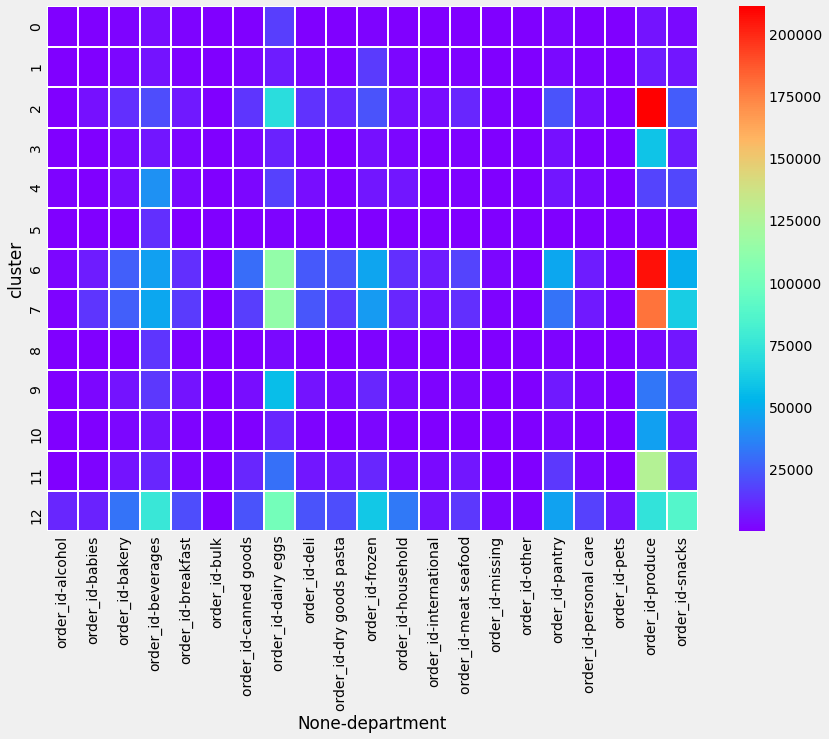

In [95]:
plt.figure(figsize=(13,9))
sns.heatmap(data=df_m.divide(avg_num_prod_per_order_by_cluster.values, axis=0), cmap="rainbow", linewidths=1)
plt.show()

## 2.8 Exporting our clustered dataframe to pyarrow (for compression) for use in collaborative filtering algorithm.

In [46]:
dummy_df = all_orders_cluster[["order_id", "product_id", "cluster", "user_id"]]

In [27]:
table = pa.Table.from_pandas(dummy_df, preserve_index=False)

pq.write_table(table, f"dummy_k{k}.parquet")

ModuleNotFoundError: No module named 'pyarrow'

## Link to [3. item2vec](recommender_system/item2vec.ipynb) 